## Environment

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report


## Loading CIFAR-10 Dataset

For this project, we used CIFAR10 dataset to train our model.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
print(f'Train images: {train_images.shape}')
print(f'Train labels: {train_labels.shape}')
print(f'Test images: {test_images.shape}')
print(f'Test labels: {test_labels.shape}')

Train images: (50000, 32, 32, 3)
Train labels: (50000, 1)
Test images: (10000, 32, 32, 3)
Test labels: (10000, 1)


From the dataset, we can see that each image is a 32*32 pixel RGB image and there are 50000 images in training dataset, 10000 images in test dataset. Labels show the class for each image belongs.


# EDA

<ipython-input-4-870663493e52>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(class_names[int(train_labels[i])])


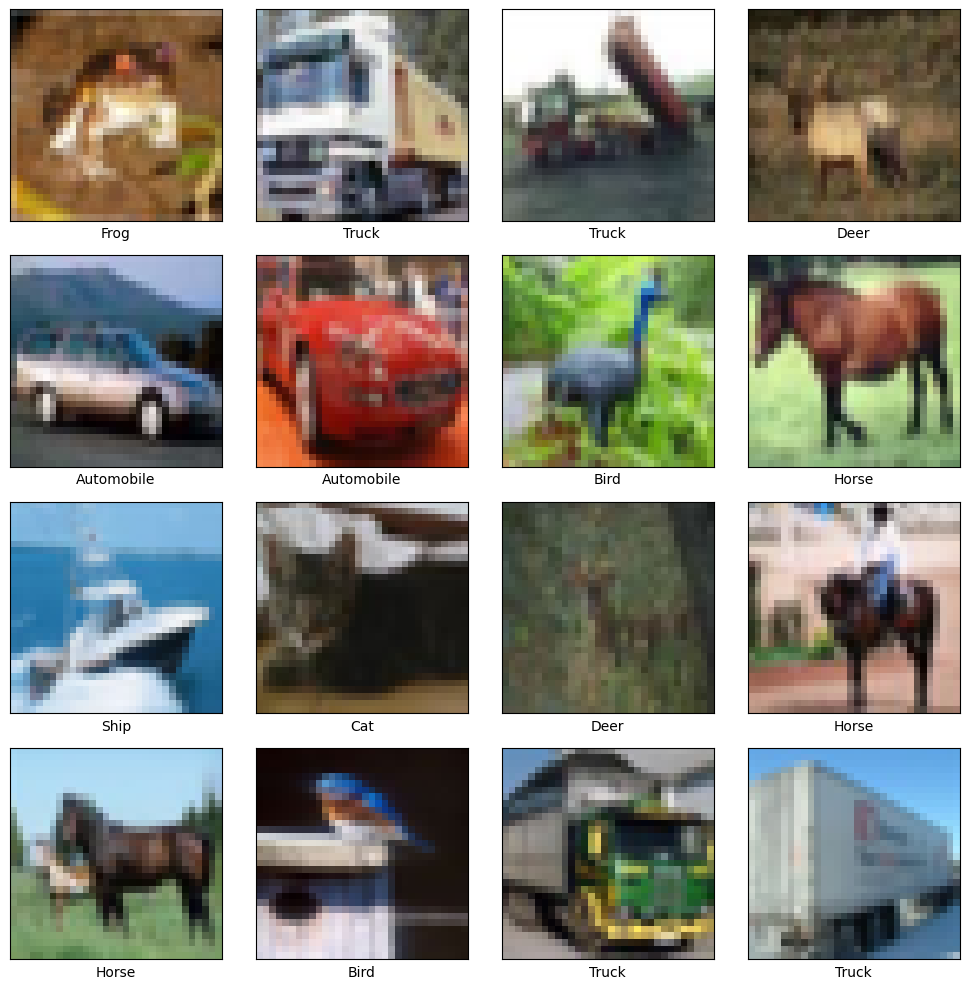

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [4]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i])
    plt.xlabel(class_names[int(train_labels[i])])
plt.tight_layout()
plt.show()

unique, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

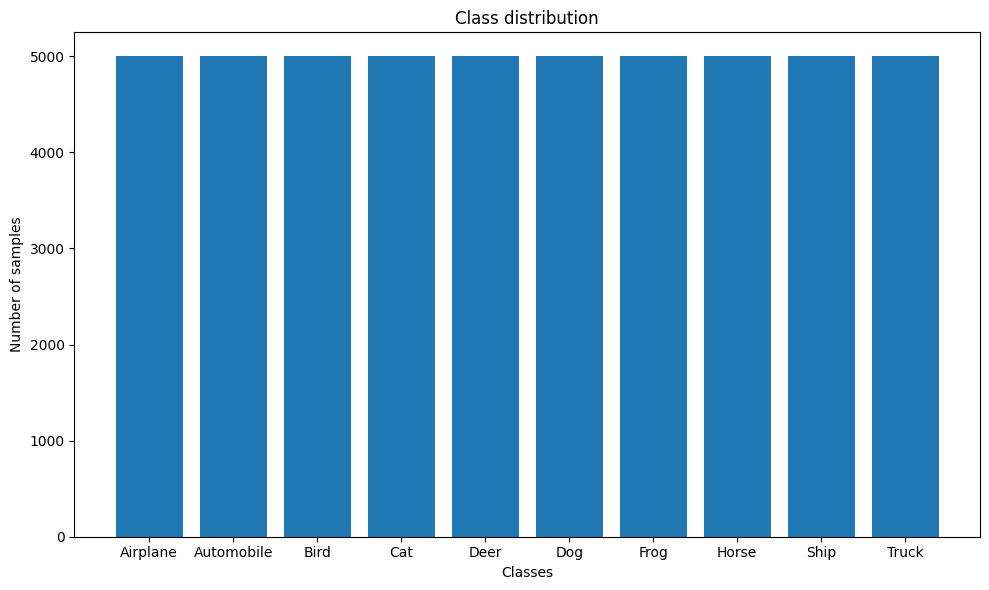

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Classes')   
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.tight_layout()
plt.show()

# Normalization

Here we check the pixel values of images

In [6]:
print(train_images.min())
print(train_images.max())

0
255


Normalize the images to a range of 0 to 1 by dividing by 255

In [7]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

print(train_images.min())
print(train_images.max())

0.0
1.0


## Split the data

We split the training and validation dataset to be 80:20

In [8]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
print(train_images.shape)
print(val_images.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


## Base CNN Model

Here we build a base CNN model to train the CIFAR-10 dataset, we use 3 convolutional layers with BatchNormalization. For the activation we choose relu because of it's commonly used in CNN model, efficient, good performance, and good to solve the vanishing gradient problem. For the first layer, we use 32 filters, 3*3 kernel, with layer 2 and 3, we use 64 filters, 3*3 kernel. Also adding dropout for preventing overfitting. For the output layer, we will get 10 neurons for 10 classes.

In [9]:
base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(10)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


For the optimizer we always choose adam because of it's one of the most powerful optimizer, also adding loss function and metrics to be the evaluation. Earlystopping for overfitting, batch size we use 128 at first, after finding the best model we will find the best parameter.

In [10]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_base = base_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.3097 - loss: 2.0666 - val_accuracy: 0.1179 - val_loss: 2.8649
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5080 - loss: 1.3743 - val_accuracy: 0.4393 - val_loss: 1.5376
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5746 - loss: 1.1993 - val_accuracy: 0.5379 - val_loss: 1.3229
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6127 - loss: 1.0972 - val_accuracy: 0.6115 - val_loss: 1.0983
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6510 - loss: 0.9947 - val_accuracy: 0.6351 - val_loss: 1.0315
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6689 - loss: 0.9399 - val_accuracy: 0.6703 - val_loss: 0.9216
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6863 - loss: 0.8962 - val_accuracy: 0.6516 - val_loss: 0.9847
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6948 - loss: 0.8619 - val_accuracy: 

For the base model, the result seems not bad, 76% of accuracy and 0.70 of test loss.

In [11]:
val_loss_base, val_accuracy_base = base_model.evaluate(val_images, val_labels)
print(f'Test Loss: {val_loss_base:.4f}')
print(f'Test Accuracy: {val_accuracy_base:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7634 - loss: 0.6972
Test Loss: 0.7080
Test Accuracy: 0.7653


In [12]:
history_dict_base = history_base.history
train_acc_base = history_dict_base['accuracy']
val_acc_base = history_dict_base['val_accuracy']
epochs_range_base = range(1, len(train_acc_base) + 1)


From two graphs we can see that the training accuracy/loss curves are consistent, both of them are steady increase/decrease at similar points. However, for validation seems perform not well, means having difficulties generalizing to the validation dataset.

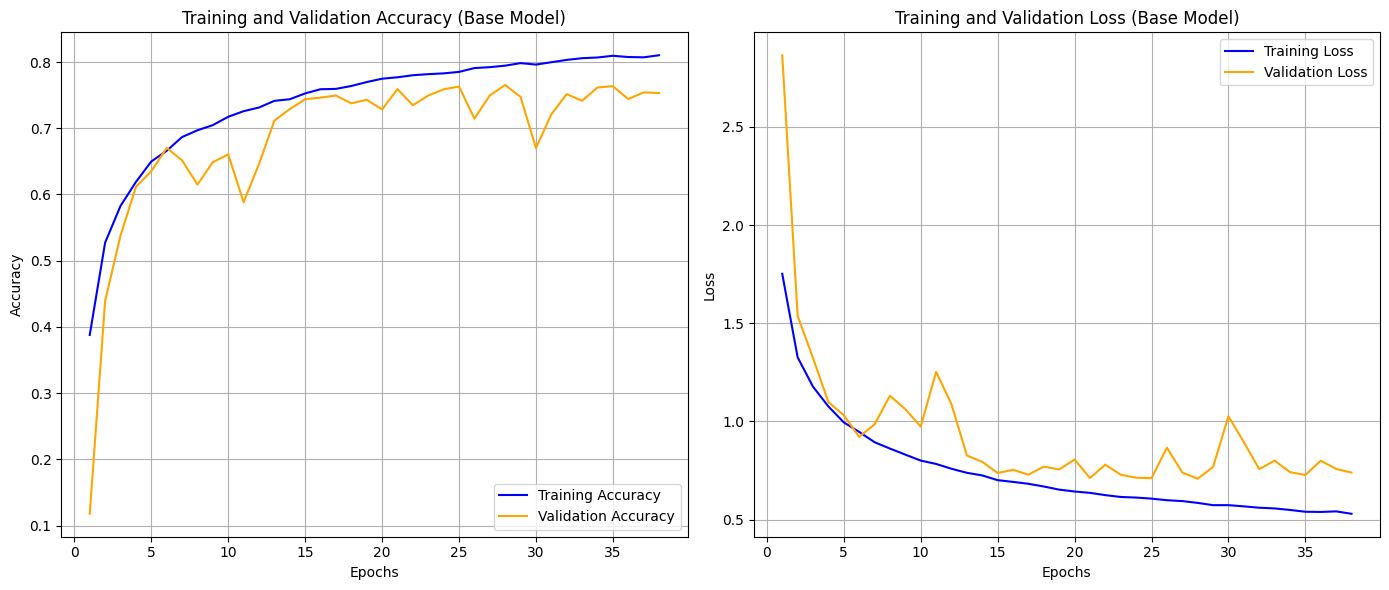

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_base, train_acc_base, label='Training Accuracy', color='blue')
plt.plot(epochs_range_base, val_acc_base, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Base Model)')
plt.legend(loc='lower right')
plt.grid(True)

train_loss_base = history_dict_base['loss']
val_loss_base = history_dict_base['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs_range_base, train_loss_base, label='Training Loss', color='blue')
plt.plot(epochs_range_base, val_loss_base, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Base Model)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


For the confusion matrix, it shows that the values on the diagonal are relatively high, meaning good accuracy for many classes. However, for dog and cat labels, they are big issue for the model to classify the difference between them.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


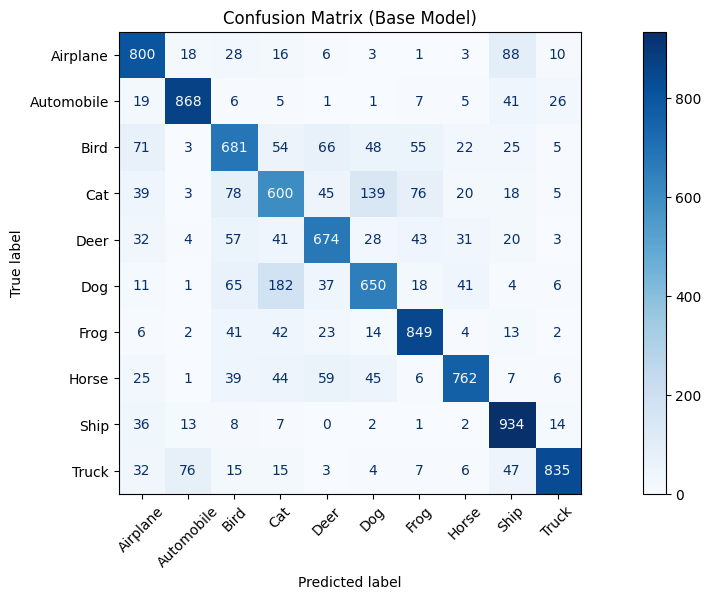

In [14]:
y_pred_base = base_model.predict(val_images)
y_pred_classes = np.argmax(y_pred_base, axis=1)
y_true = val_labels.flatten()

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(16, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Confusion Matrix (Base Model)')
plt.show()

# CNN ResNet18 Model

ResNet basic model

For the CNN ResNet 18 model, we tried to use ImageDataGenerator for preprocessing and augmentation, however, once we use the generator, the accuracy becomes much worse than without generator. Thus, we get rid of the generator.

For the basic Resnet model, we create two layers with Batchnormalization, relu activation, and He normal method to initialize weights.

In [15]:
def resnet_block(input_tensor, filters, strides=1):
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x

ResNet 18 model

In [16]:
def resnet18(input_shape=(32, 32, 3), num_classes=10, dropout_rate = 0.3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce dimensions
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

resnet18_model = resnet18()

For Resnet18, we add lr schedule for adjusting the learning rate dynamically to ensure better convergence during training.

In [17]:
resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_resnet18 = resnet18_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.3570 - loss: 2.1103 - val_accuracy: 0.2059 - val_loss: 3.3335 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.5675 - loss: 1.2512 - val_accuracy: 0.5239 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6554 - loss: 1.0011 - val_accuracy: 0.5149 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6903 - loss: 0.8970 - val_accuracy: 0.6416 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7360 - loss: 0.7635 - val_accuracy: 0.6036 - val_loss: 1.2599 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7710 - loss: 0.6675 - val_accuracy: 0.6220 - val_loss: 1.1845 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accura

For the validation accuracy 70% and loss 0.89, both of them are a little bit lower than base model.

In [18]:
val_loss_res, val_accuracy_res = resnet18_model.evaluate(val_images, val_labels, batch_size=128)
print(f'ResNet Val Loss: {val_loss_res:.4f}')
print(f'ResNet Val Accuracy: {val_accuracy_res:.4f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7055 - loss: 0.8824
ResNet Val Loss: 0.8901
ResNet Val Accuracy: 0.7073


In [19]:
history_dict = history_resnet18.history
train_acc_res = history_dict['accuracy']
val_acc_res = history_dict['val_accuracy']
train_loss_res = history_dict['loss']
val_loss_res = history_dict['val_loss']
epochs_range_res = range(1, len(train_acc_res) + 1)

From the accuracy/loss graphs, we can see that for training part it is steady and well performance, but it cannot generate validation dataset well.

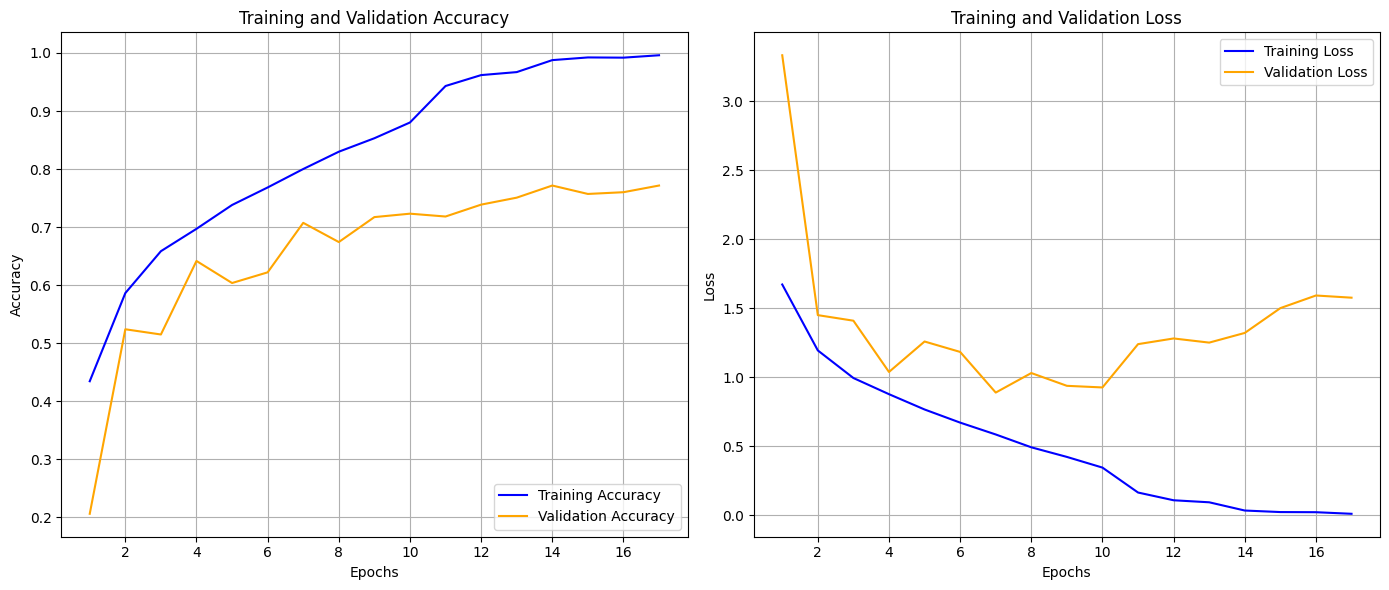

In [20]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_res, train_acc_res, label='Training Accuracy', color='blue')
plt.plot(epochs_range_res, val_acc_res, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_res, train_loss_res, label='Training Loss', color='blue')
plt.plot(epochs_range_res, val_loss_res, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

The confusion matrix shows the weak learning from cat and dog, also between automobile and ship shows a similar problem.

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


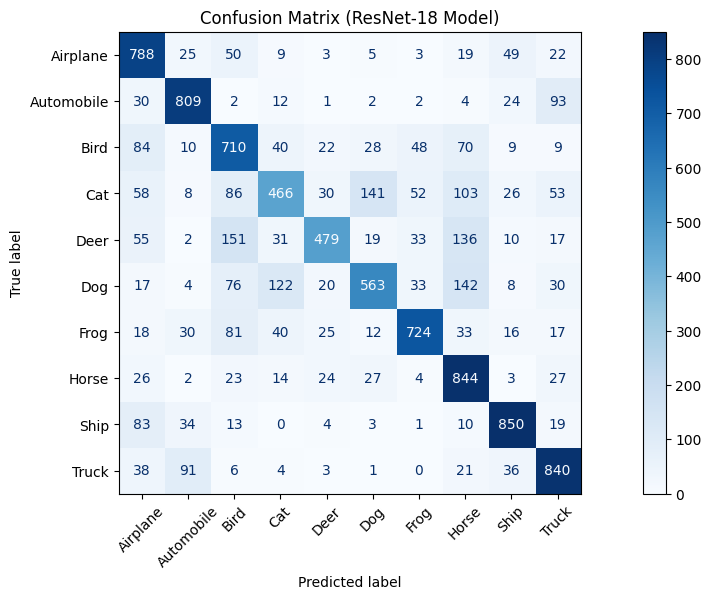

In [21]:
y_pred_probs = resnet18_model.predict(val_images, batch_size=128)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(val_labels.flatten(), y_pred_classes)

plt.figure(figsize=(16, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Confusion Matrix (ResNet-18 Model)')
plt.show()

## MobileNetV2 Model

Here we use pre-trained model MobileNetV2 to be our third model. It uses dephwise separable convolutions to reduce the number of parameters, which helps in making the model lightweight.

First we import the MobileNetV2 with pre-train weights and freeze the first 110 layers for feature extracting.

In [22]:
MobileNet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in MobileNet_model.layers[:110]:
    layer.trainable = False

<ipython-input-22-23eb6f5d17bb>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


FOr the hyperparameter we remain the same with Resnet18 model to be good comparison.

In [23]:
model_mobile = models.Sequential([
    MobileNet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])


model_mobile.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_mobile = model_mobile.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size = 128,
    callbacks = [early_stopping, lr_scheduler]
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.4013 - loss: 2.0879 - val_accuracy: 0.1638 - val_loss: 5.6538 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6515 - loss: 1.2119 - val_accuracy: 0.1240 - val_loss: 7.5416 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7017 - loss: 0.9879 - val_accuracy: 0.1390 - val_loss: 5.9716 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7348 - loss: 0.8510 - val_accuracy: 0.3332 - val_loss: 3.8541 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7609 - loss: 0.7464 - val_accuracy: 0.4541 - val_loss: 2.3323 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7815 - loss: 0.6829 - val_accuracy: 0.5384 - val_loss: 2.0874 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8014 - loss: 0

The accuracy and loss seems not performing well with accuracy 62% and 1.31 loss.

In [24]:
val_loss_mobile, val_accuracy_mobile = model_mobile.evaluate(val_images, val_labels, batch_size=128)
print(f'Mobile Val Loss: {val_loss_mobile:.4f}')
print(f'Mobile Val Accuracy: {val_accuracy_mobile:.4f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6978 - loss: 1.4366
Mobile Val Loss: 1.4737
Mobile Val Accuracy: 0.6938


In [25]:
history_dict_mob = history_mobile.history
train_acc_mobile = history_dict_mob['accuracy']
val_acc_mobile = history_dict_mob['val_accuracy']
train_loss_mobile = history_dict_mob['loss']
val_loss_mobile = history_dict_mob['val_loss']
epochs_range_mobile = range(1, len(train_acc_mobile) + 1)

From the confusion matrix, the validation dataset was not well consistent with training curve.

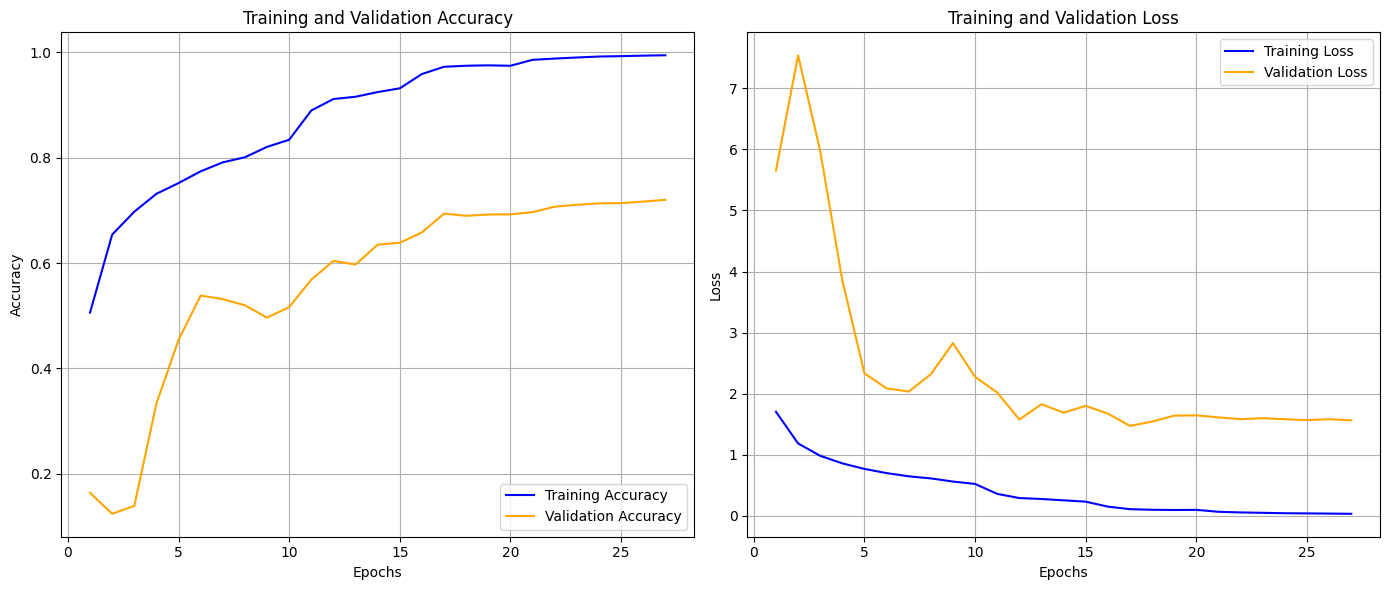

In [26]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_mobile, train_acc_mobile, label='Training Accuracy', color='blue')
plt.plot(epochs_range_mobile, val_acc_mobile, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_mobile, train_loss_mobile, label='Training Loss', color='blue')
plt.plot(epochs_range_mobile, val_loss_mobile, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

The label cat can not classify well with dog label, showing the model doesn't learn well.

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


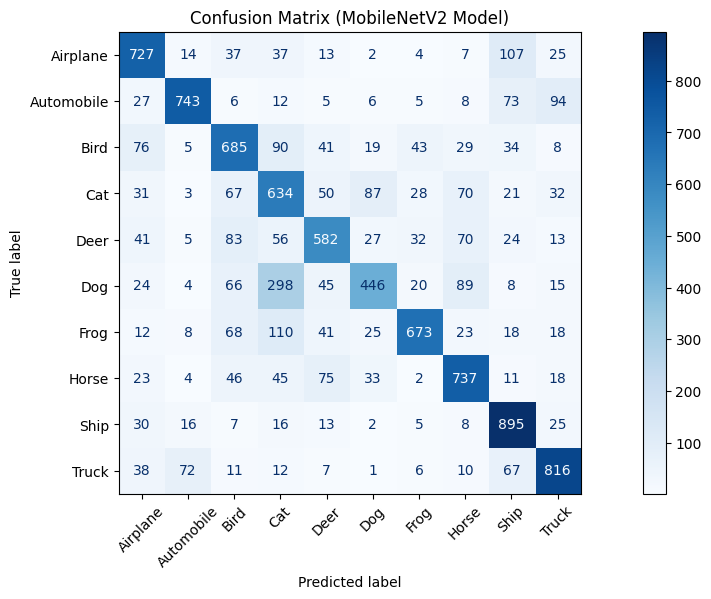

In [27]:
y_pred_probs = model_mobile.predict(val_images, batch_size=128)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(val_labels.flatten(), y_pred_classes)

plt.figure(figsize=(16, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Confusion Matrix (MobileNetV2 Model)')
plt.show()

## Comparison

For this part, we tried to do the comparison to get the best model. From the accuracy/loss graphs, we can see that base model performs the best.

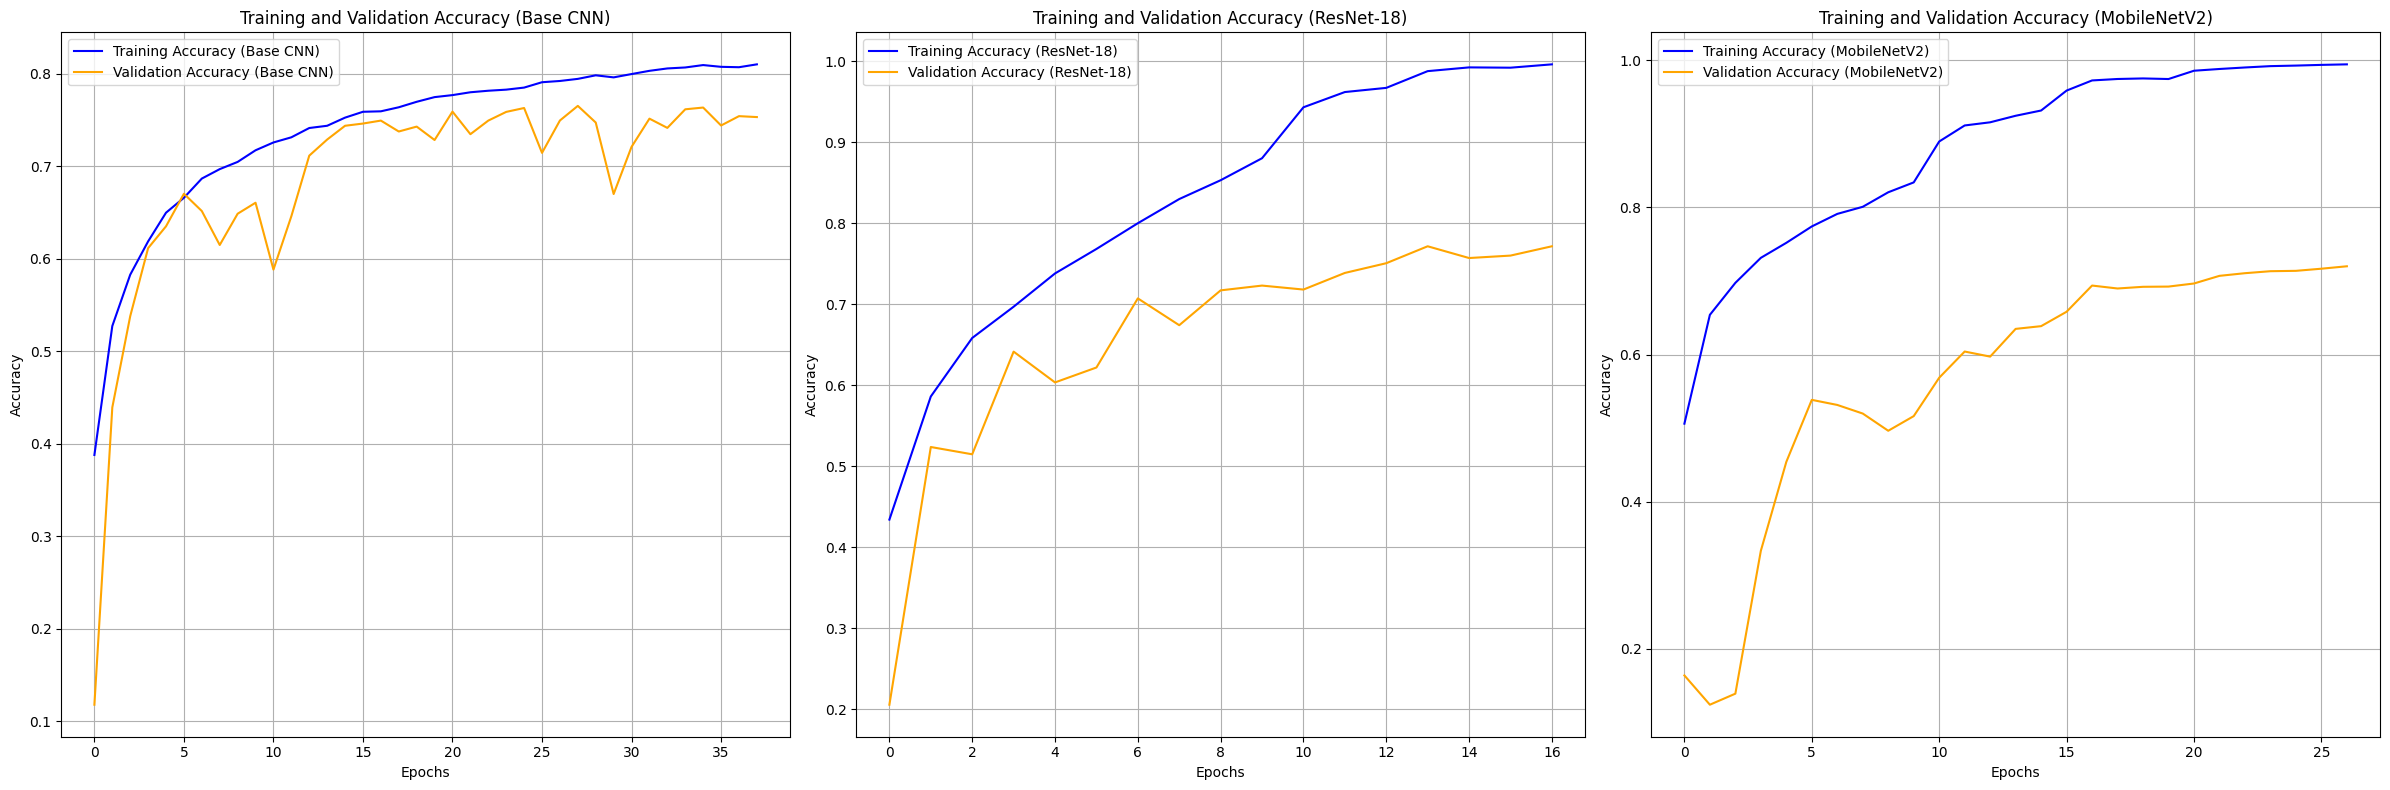

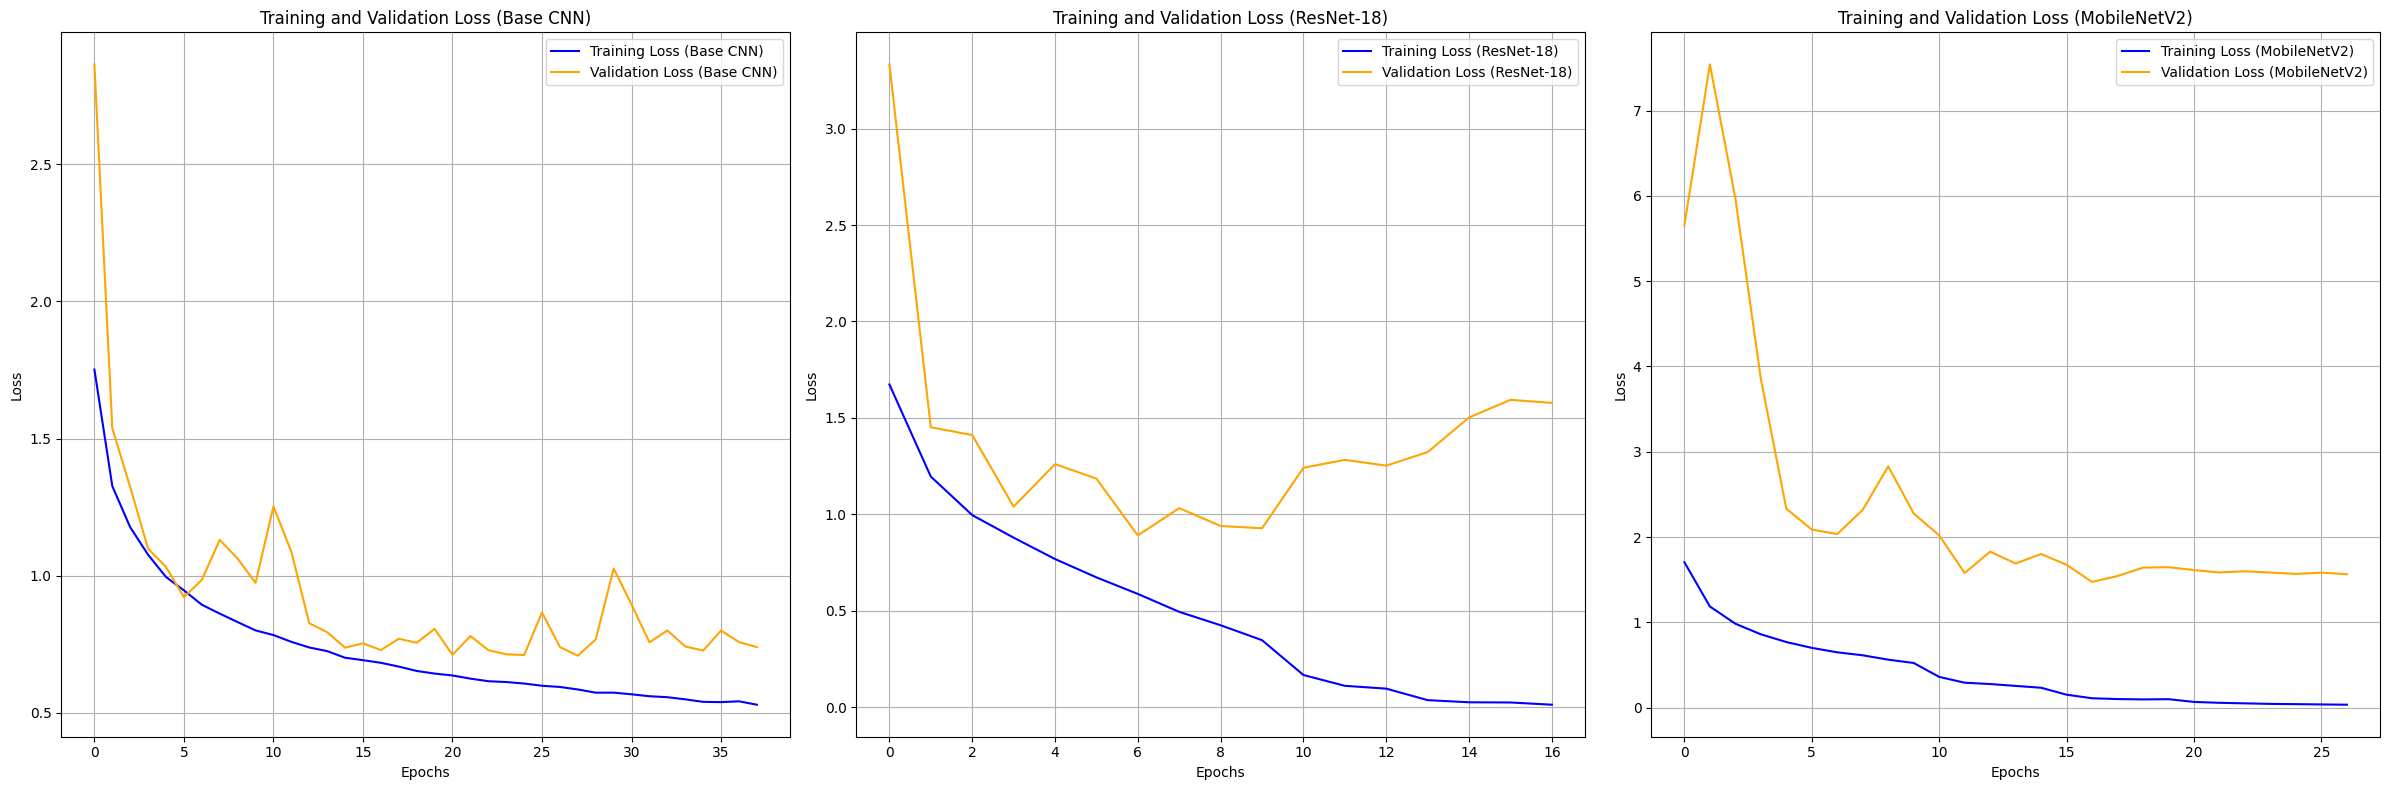

In [28]:

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.plot(history_base.history['accuracy'], label='Training Accuracy (Base CNN)', color='blue')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy (Base CNN)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Base CNN)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_resnet18.history['accuracy'], label='Training Accuracy (ResNet-18)', color='blue')
plt.plot(history_resnet18.history['val_accuracy'], label='Validation Accuracy (ResNet-18)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ResNet-18)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_mobile.history['accuracy'], label='Training Accuracy (MobileNetV2)', color='blue')
plt.plot(history_mobile.history['val_accuracy'], label='Validation Accuracy (MobileNetV2)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.plot(history_base.history['loss'], label='Training Loss (Base CNN)', color='blue')
plt.plot(history_base.history['val_loss'], label='Validation Loss (Base CNN)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Base CNN)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_resnet18.history['loss'], label='Training Loss (ResNet-18)', color='blue')
plt.plot(history_resnet18.history['val_loss'], label='Validation Loss (ResNet-18)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet-18)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_mobile.history['loss'], label='Training Loss (MobileNetV2)', color='blue')
plt.plot(history_mobile.history['val_loss'], label='Validation Loss (MobileNetV2)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


From base model, it is significant better than others, but there is no much diffience between ResNet18 and MobileNetV2s.

In [29]:
print(f'Base Model Accuracy: {val_accuracy_base:.4f}')
print(f'ResNet-18 Model Accuracy: {val_accuracy_res:.4f}')
print(f'MobileNetV2 Model Accuracy: {val_accuracy_mobile:.4f}')


Base Model Accuracy: 0.7653
ResNet-18 Model Accuracy: 0.7073
MobileNetV2 Model Accuracy: 0.6938


For the confusion matrix, three of them were facing some similar challenging for cat and dog labels.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


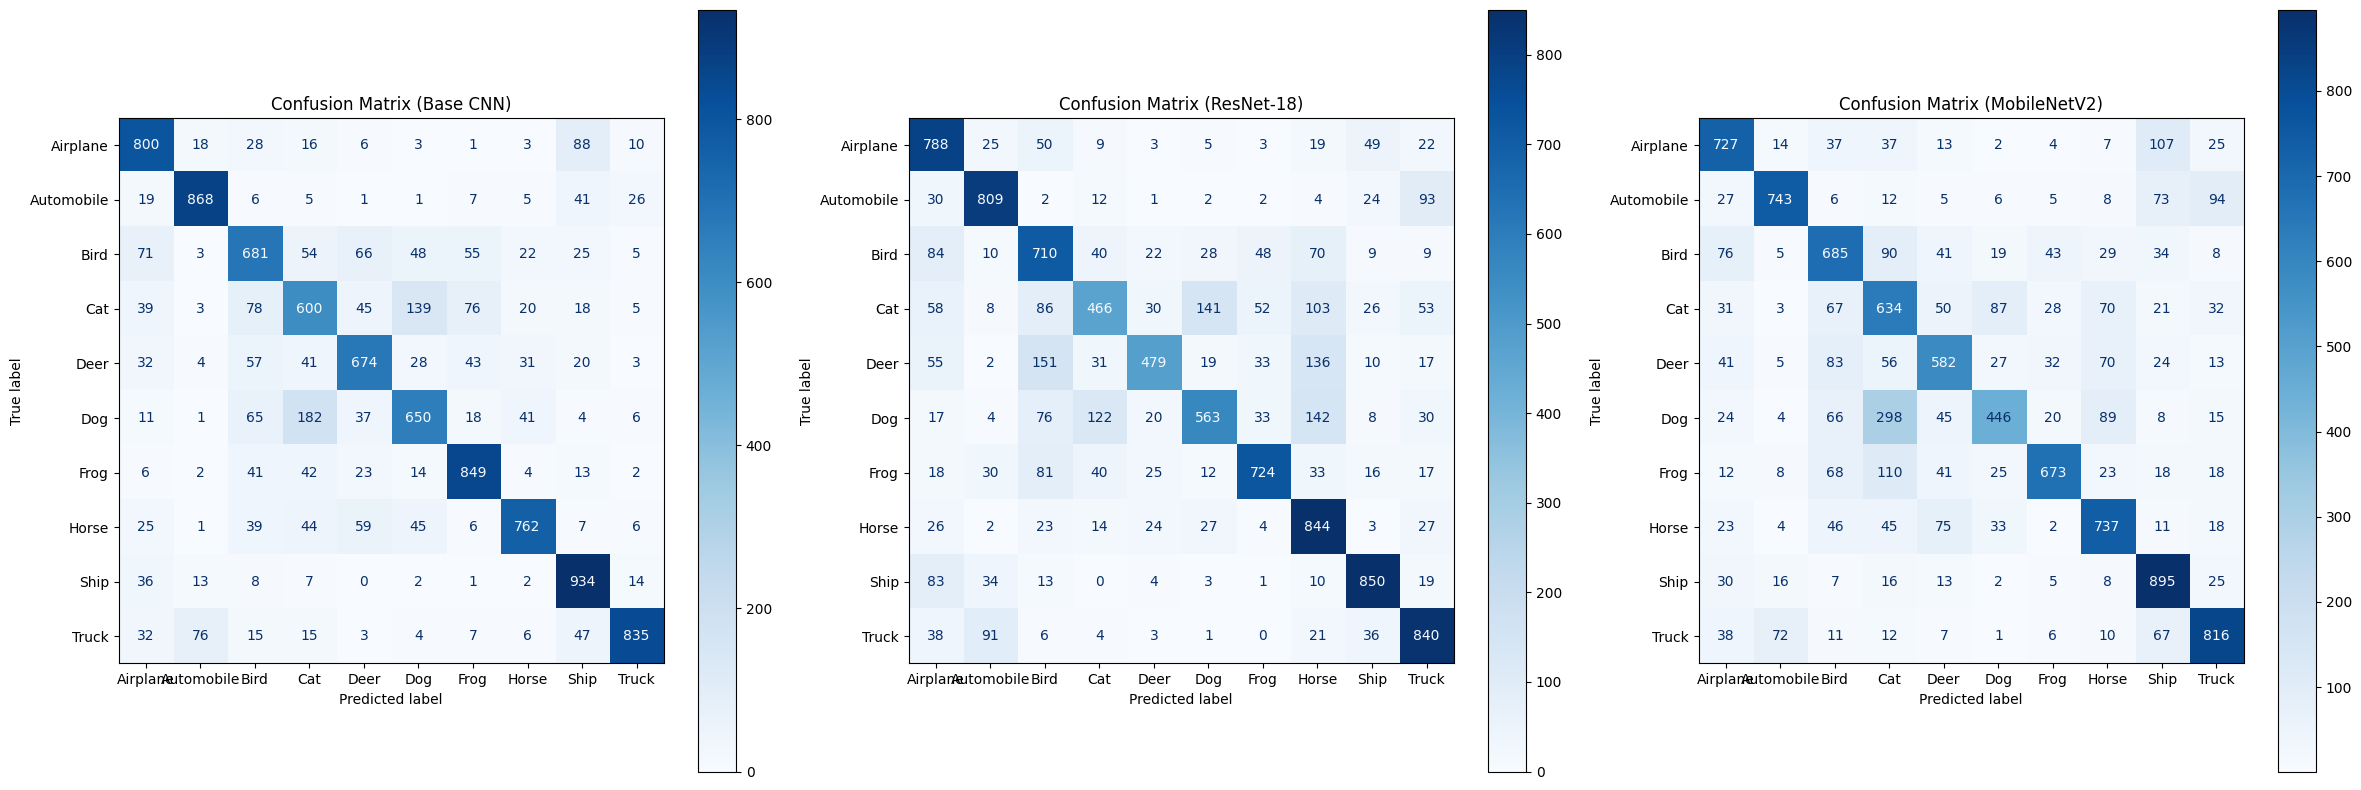

In [30]:
y_pred_base = np.argmax(base_model.predict(val_images), axis=1)
y_pred_resnet18 = np.argmax(resnet18_model.predict(val_images), axis=1)
y_pred_mobile = np.argmax(model_mobile.predict(val_images), axis=1)

y_true = val_labels.flatten()

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
conf_matrix_base = confusion_matrix(y_true, y_pred_base)
disp_base = ConfusionMatrixDisplay(conf_matrix_base, display_labels=class_names)
disp_base.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (Base CNN)')

plt.subplot(1, 3, 2)
conf_matrix_resnet18 = confusion_matrix(y_true, y_pred_resnet18)
disp_resnet18 = ConfusionMatrixDisplay(conf_matrix_resnet18, display_labels=class_names)
disp_resnet18.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (ResNet-18)')

plt.subplot(1, 3, 3)
conf_matrix_mobile = confusion_matrix(y_true, y_pred_mobile)
disp_mobile = ConfusionMatrixDisplay(conf_matrix_mobile, display_labels=class_names)
disp_mobile.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (MobileNetV2)')

plt.tight_layout()
plt.show()


In [31]:
print("Classification Report (Base CNN):")
print(classification_report(y_true, y_pred_base, target_names=class_names))

print("Classification Report (ResNet-18):")
print(classification_report(y_true, y_pred_resnet18, target_names=class_names))

print("Classification Report (MobileNetV2):")
print(classification_report(y_true, y_pred_mobile, target_names=class_names))


Classification Report (Base CNN):
              precision    recall  f1-score   support

    Airplane       0.75      0.82      0.78       973
  Automobile       0.88      0.89      0.88       979
        Bird       0.67      0.66      0.67      1030
         Cat       0.60      0.59      0.59      1023
        Deer       0.74      0.72      0.73       933
         Dog       0.70      0.64      0.67      1015
        Frog       0.80      0.85      0.82       996
       Horse       0.85      0.77      0.81       994
        Ship       0.78      0.92      0.84      1017
       Truck       0.92      0.80      0.86      1040

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000

Classification Report (ResNet-18):
              precision    recall  f1-score   support

    Airplane       0.66      0.81      0.73       973
  Automobile       0.80      0.83      0.81       979
        B

After we do the comparison, we found that base CNN model performs the best. Also the validation accuracy/loss of base model performs much better than ResNet18 and MobileNet model. Thus, we will proceed with base CNN model to be the final model.

## Finding the best hyperparameter for base model

### Learning Rate Tuning

In [32]:
learning_rates = [0.001, 0.001, 0.01]
results_learning_rate = []

for learning_rate in learning_rates:
    print(f"\nTraining with learning_rate={learning_rate}")

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(10)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=30,
        batch_size=128,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    results_learning_rate.append({
        'learning_rate': learning_rate,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history
    })

    best_learning_rate_result = max(results_learning_rate, key=lambda x: x['val_accuracy'])
    best_learning_rate = best_learning_rate_result['learning_rate']
    print(f"\nBest Learning Rate: {best_learning_rate}, Validation Accuracy: {best_learning_rate_result['val_accuracy']:.4f}")



Training with learning_rate=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3164 - loss: 2.0520 - val_accuracy: 0.1134 - val_loss: 3.4672 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5049 - loss: 1.3862 - val_accuracy: 0.5080 - val_loss: 1.3553 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5710 - loss: 1.2091 - val_accuracy: 0.5942 - val_loss: 1.1192 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6130 - loss: 1.1020 - val_accuracy: 0.6118 - val_loss: 1.1048 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6466 - loss: 1.0064 - val_accuracy: 0.5836 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6678 - loss: 0.9516 - val_accuracy: 0.6399 - val_loss: 1.0329 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6876 - loss: 0.8923 

### Batch Size Tuning

In [33]:
batch_sizes = [64, 128, 256]
results_batch_size = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch_size={batch_size}")

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(10)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=30,
        batch_size=batch_size,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    results_batch_size.append({
        'batch_size': batch_size,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history
    })

best_batch_size_result = max(results_batch_size, key=lambda x: x['val_accuracy'])
best_batch_size = best_batch_size_result['batch_size']
print(f"\nBest Batch Size: {best_batch_size}, Validation Accuracy: {best_batch_size_result['val_accuracy']:.4f}")



Training with batch_size=64
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3314 - loss: 1.9469 - val_accuracy: 0.4332 - val_loss: 1.5748 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5284 - loss: 1.3258 - val_accuracy: 0.5828 - val_loss: 1.1652 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5963 - loss: 1.1496 - val_accuracy: 0.5565 - val_loss: 1.2117 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6366 - loss: 1.0288 - val_accuracy: 0.6253 - val_loss: 1.0665 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6665 - loss: 0.9566 - val_accuracy: 0.6279 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6827 - loss: 0.9147 - val_accuracy: 0.6915 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accu

### Dropout Rate Tuning

In [34]:
dropout_rates = [0.2, 0.3, 0.5]
results_dropout_rate = []

for dropout_rate in dropout_rates:
    print(f"\nTraining with dropout_rate={dropout_rate}")

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(10)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=30,
        batch_size=best_batch_size,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    val_loss, val_accuracy = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    results_dropout_rate.append({
        'dropout_rate': dropout_rate,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history
    })

best_dropout_rate_result = max(results_dropout_rate, key=lambda x: x['val_accuracy'])
best_dropout_rate = best_dropout_rate_result['dropout_rate']
print(f"\nBest Dropout Rate: {best_dropout_rate}, Validation Accuracy: {best_dropout_rate_result['val_accuracy']:.4f}")



Training with dropout_rate=0.2
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3588 - loss: 1.8602 - val_accuracy: 0.5006 - val_loss: 1.3739 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5765 - loss: 1.2074 - val_accuracy: 0.6410 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6377 - loss: 1.0355 - val_accuracy: 0.6482 - val_loss: 0.9942 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6727 - loss: 0.9326 - val_accuracy: 0.6640 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6987 - loss: 0.8567 - val_accuracy: 0.6444 - val_loss: 1.0407 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7187 - loss: 0.8084 - val_accuracy: 0.6390 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - a

In [35]:
best_val_loss, best_val_accuracy = model.evaluate(test_images, test_labels, batch_size=64)
print(f'Best Val Loss: {best_val_loss:.4f}')
print(f'Best Val Accuracy: {best_val_accuracy:.4f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7440 - loss: 0.7394
Best Val Loss: 0.7458
Best Val Accuracy: 0.7437


In [36]:
best_history_dict = history.history
best_train_acc= best_history_dict['accuracy']
best_val_acc = best_history_dict['val_accuracy']
best_train_loss = best_history_dict['loss']
best_val_loss = best_history_dict['val_loss']
best_epochs_range = range(1, len(best_train_acc) + 1)

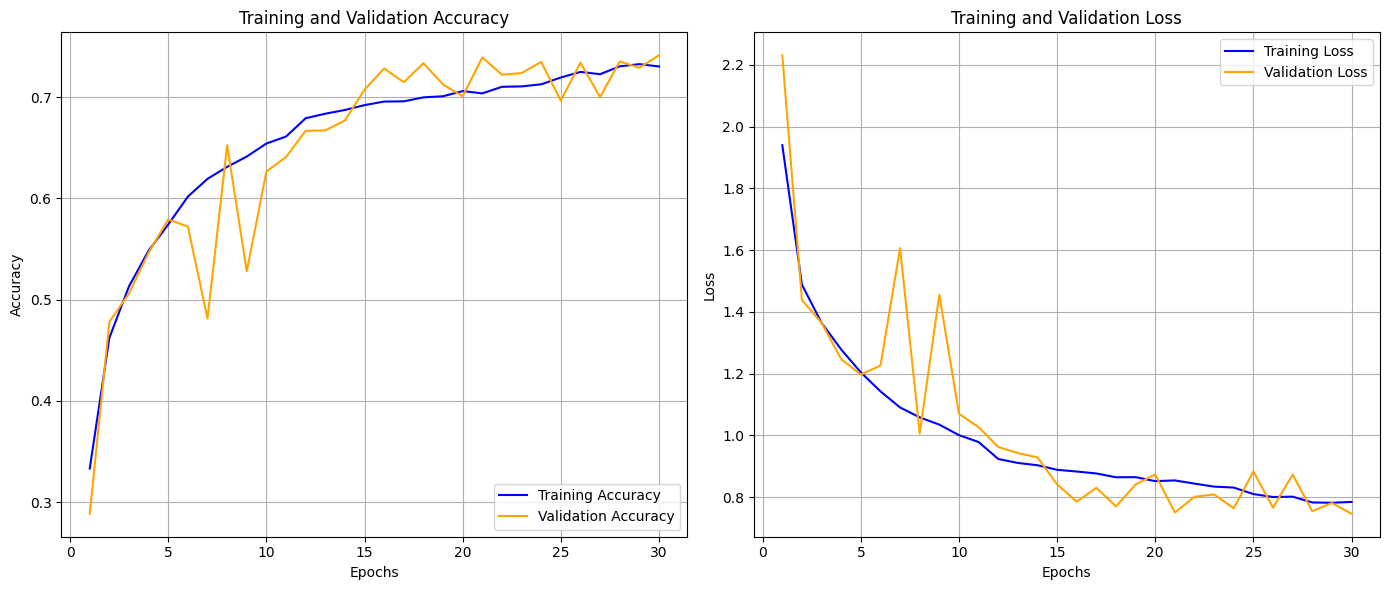

In [37]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(best_epochs_range, best_train_acc, label='Training Accuracy', color='blue')
plt.plot(best_epochs_range, best_val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_epochs_range, best_train_loss, label='Training Loss', color='blue')
plt.plot(best_epochs_range, best_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


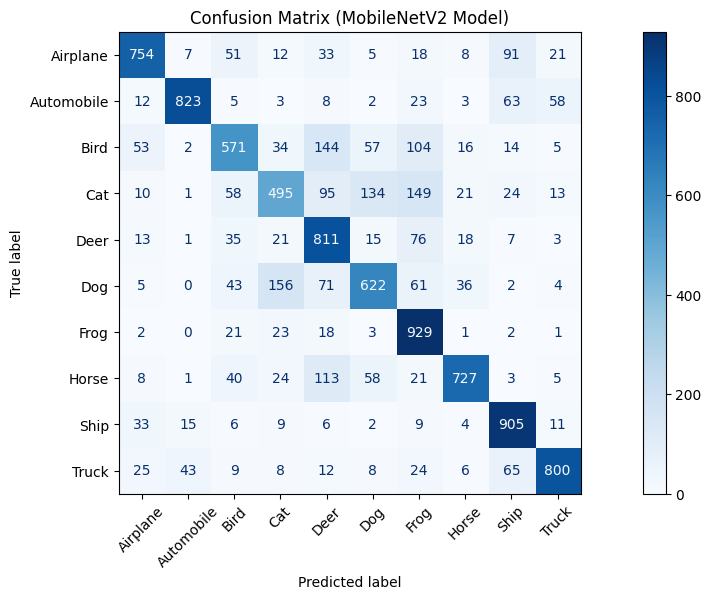

In [38]:
y_pred_probs = model.predict(test_images, batch_size=64)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(test_labels.flatten(), y_pred_classes)

plt.figure(figsize=(16, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.xticks(rotation=45)
plt.title('Confusion Matrix (MobileNetV2 Model)')
plt.show()

In [40]:
y_pred_best = np.argmax(model.predict(test_images), axis=1)
y_true = test_labels.flatten()

print("Classification Report (Best CNN):")
print(classification_report(y_true, y_pred_best, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report (Best CNN):
              precision    recall  f1-score   support

    Airplane       0.82      0.75      0.79      1000
  Automobile       0.92      0.82      0.87      1000
        Bird       0.68      0.57      0.62      1000
         Cat       0.63      0.49      0.55      1000
        Deer       0.62      0.81      0.70      1000
         Dog       0.69      0.62      0.65      1000
        Frog       0.66      0.93      0.77      1000
       Horse       0.87      0.73      0.79      1000
        Ship       0.77      0.91      0.83      1000
       Truck       0.87      0.80      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

